In [1]:
import jax
import sys
sys.path.append('tracr/')

from utils.plot import *

# The default of float16 can lead to discrepancies between outputs of
# the compiled model and the RASP program.
jax.config.update('jax_default_matmul_precision', 'float32')


from utils import compiling_all
from utils.verbose_craft import make_craft_model_verbose
from utils.craft_embeddings import embed_input

from tracr.rasp import rasp


# def make_hist() -> rasp.SOp:
#   """Returns the number of times each token occurs in the input.

#    (As implemented in the RASP paper.)

#   Example usage:
#     hist = make_hist()
#     hist("abac")
#     >> [2, 1, 2, 1]
#   """
#   same_tok = rasp.Select(rasp.tokens, rasp.tokens,
#                          rasp.Comparison.EQ).named("same_tok")
#   return rasp.SelectorWidth(same_tok).named("hist")


import tracr.compiler.lib as lib

def get_program(program_name, max_seq_len):
  """Returns RASP program and corresponding token vocabulary."""
  if program_name == "length":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_length()
    input_seq = "abbbc"
  elif program_name == "frac_prevs":
    vocab = {"a", "b", "c", "x"}
    program = lib.make_frac_prevs((rasp.tokens == "x").named("is_x"))
    input_seq = "abxxc"
  elif program_name == "dyck-2":
    vocab = {"(", ")", "{", "}"}
    program = lib.make_shuffle_dyck(pairs=["()", "{}"])
    input_seq = "{(})"
  elif program_name == "dyck-3":
    vocab = {"(", ")", "{", "}", "[", "]"}
    program = lib.make_shuffle_dyck(pairs=["()", "{}", "[]"])
    input_seq = "{(}[])"
  elif program_name == "sort":
    vocab = {1, 2, 3, 4, 5}
    program = lib.make_sort(
        rasp.tokens, rasp.tokens, max_seq_len=max_seq_len, min_key=1)
    input_seq = [3,2,3,5,2]
  elif program_name == "sort_unique":
    vocab = {1, 2, 3, 4, 5}
    program = lib.make_sort_unique(rasp.tokens, rasp.tokens)
    input_seq = [3,2,1,5,2]
  elif program_name == "hist":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_hist()
    input_seq = "abccd"
  elif program_name == "sort_freq":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_sort_freq(max_seq_len=max_seq_len)
    input_seq = "abcaba"
  elif program_name == "pair_balance":
    vocab = {"(", ")"}
    program = lib.make_pair_balance(
        sop=rasp.tokens, open_token="(", close_token=")")
    input_seq = "(()()"
  else:
    raise NotImplementedError(f"Program {program_name} not implemented.")
  return program, vocab, input_seq

In [2]:
prog_name = "length"
program, vocab, input_seq = get_program(prog_name, 6)
vocab = set(list(input_seq))
formatted_input = ["bos"] + list(input_seq)
max_seq_len=len(input_seq)+1

assembled_model, rasp_model, craft_model, _BOS_DIRECTION, _ONE_DIRECTION  = compiling_all.compile_rasp_to_model_returns_all(
      program=program,
      vocab=vocab,
      max_seq_len=max_seq_len,
      causal=False,
      compiler_bos="bos",
      compiler_pad="pad",
      mlp_exactness=100)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
print(f"Runnning {prog_name} with input {input_seq}")
prog_out = assembled_model.apply(formatted_input).decoded
print(f"Prgoram outputs: {prog_out}")

Runnning length with input abbbc
Prgoram outputs: ['bos', 5, 5, 5, 5, 5]


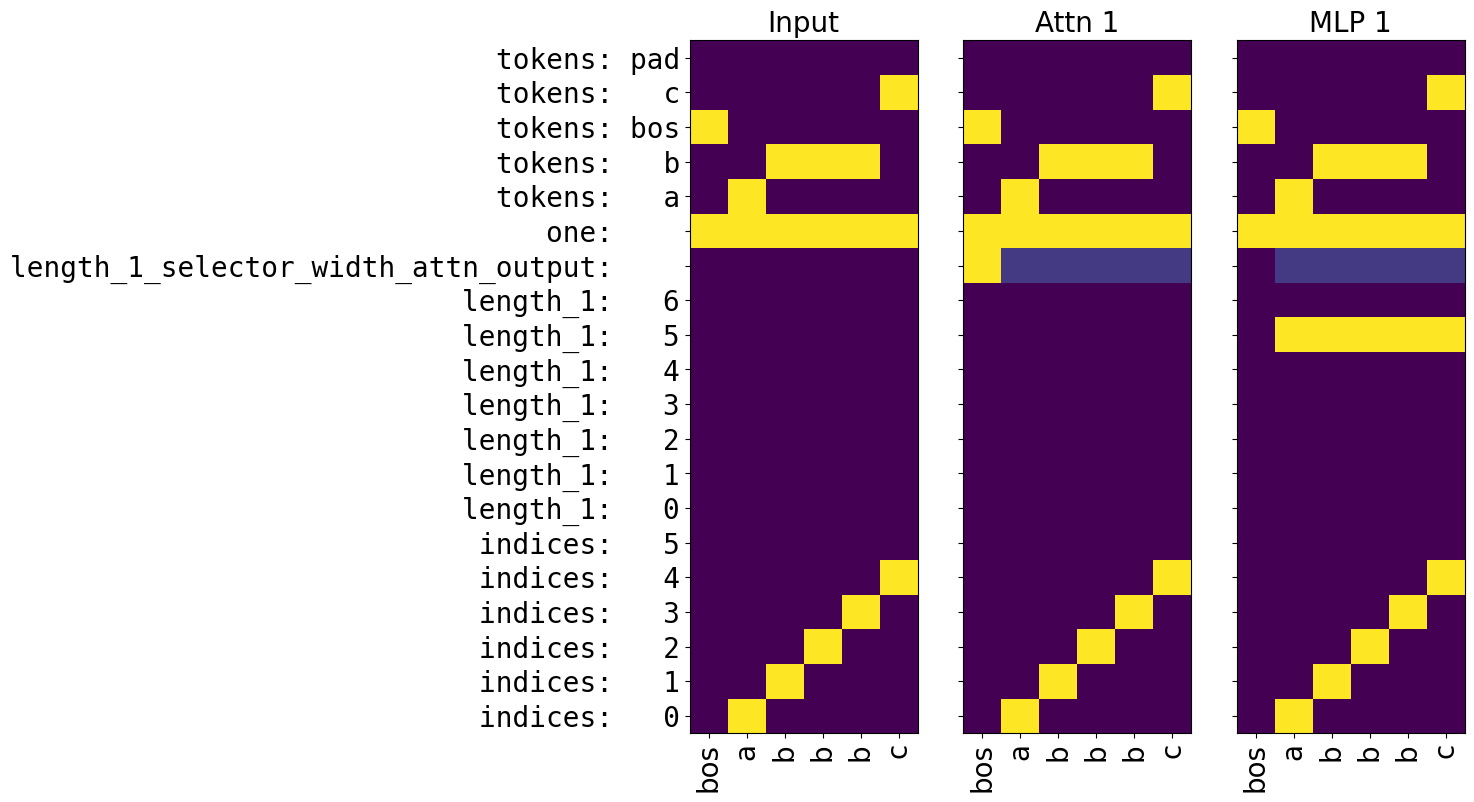

In [4]:
plot_residuals_and_input(
  model=assembled_model,
  inputs=formatted_input,
  figsize=(10, 9)
)

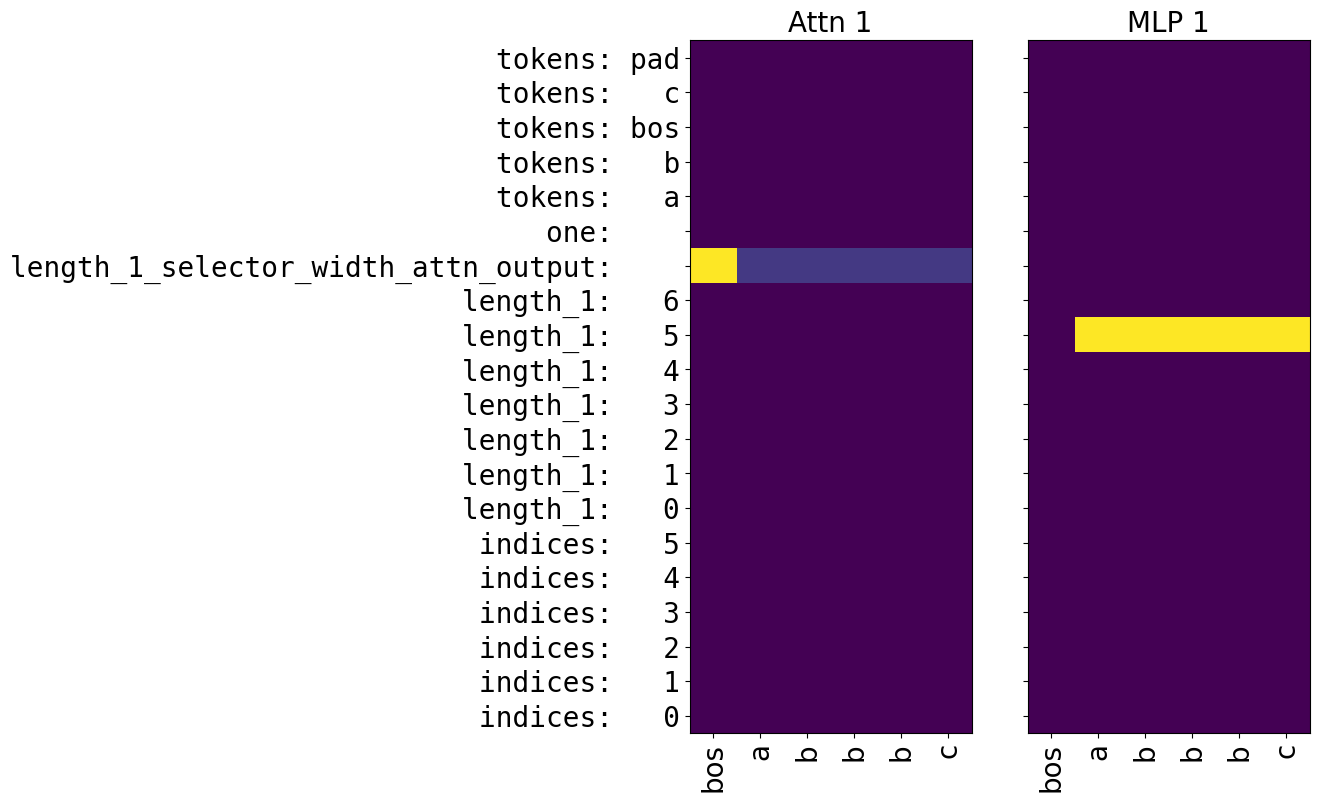

In [5]:
#@title Plot layer outputs
plot_layer_outputs(
  model=assembled_model,
  inputs = formatted_input,
  figsize=(8, 9)
)

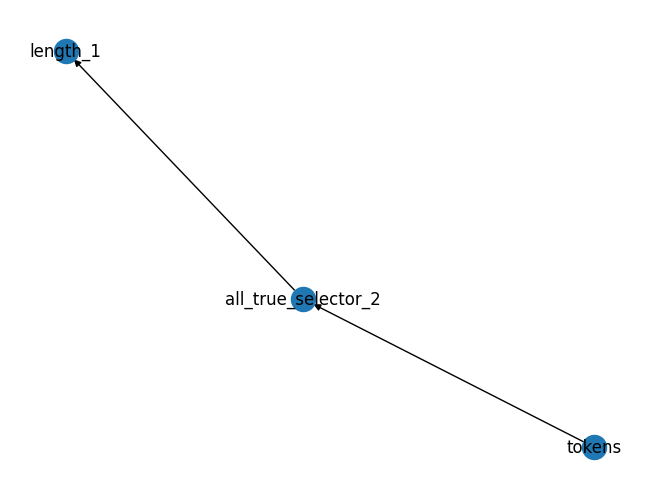

In [6]:
import networkx as nx
nx.draw(rasp_model.graph, with_labels=True)

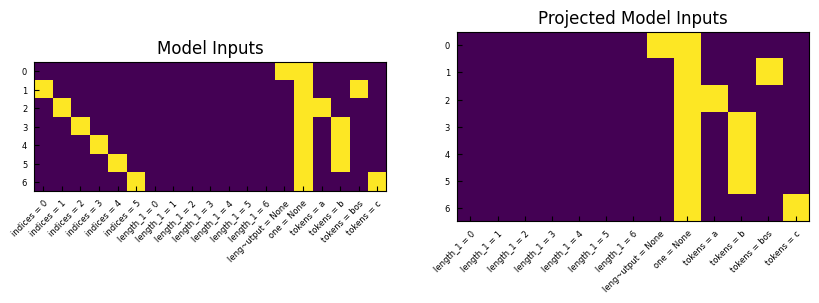

<Figure size 640x480 with 0 Axes>

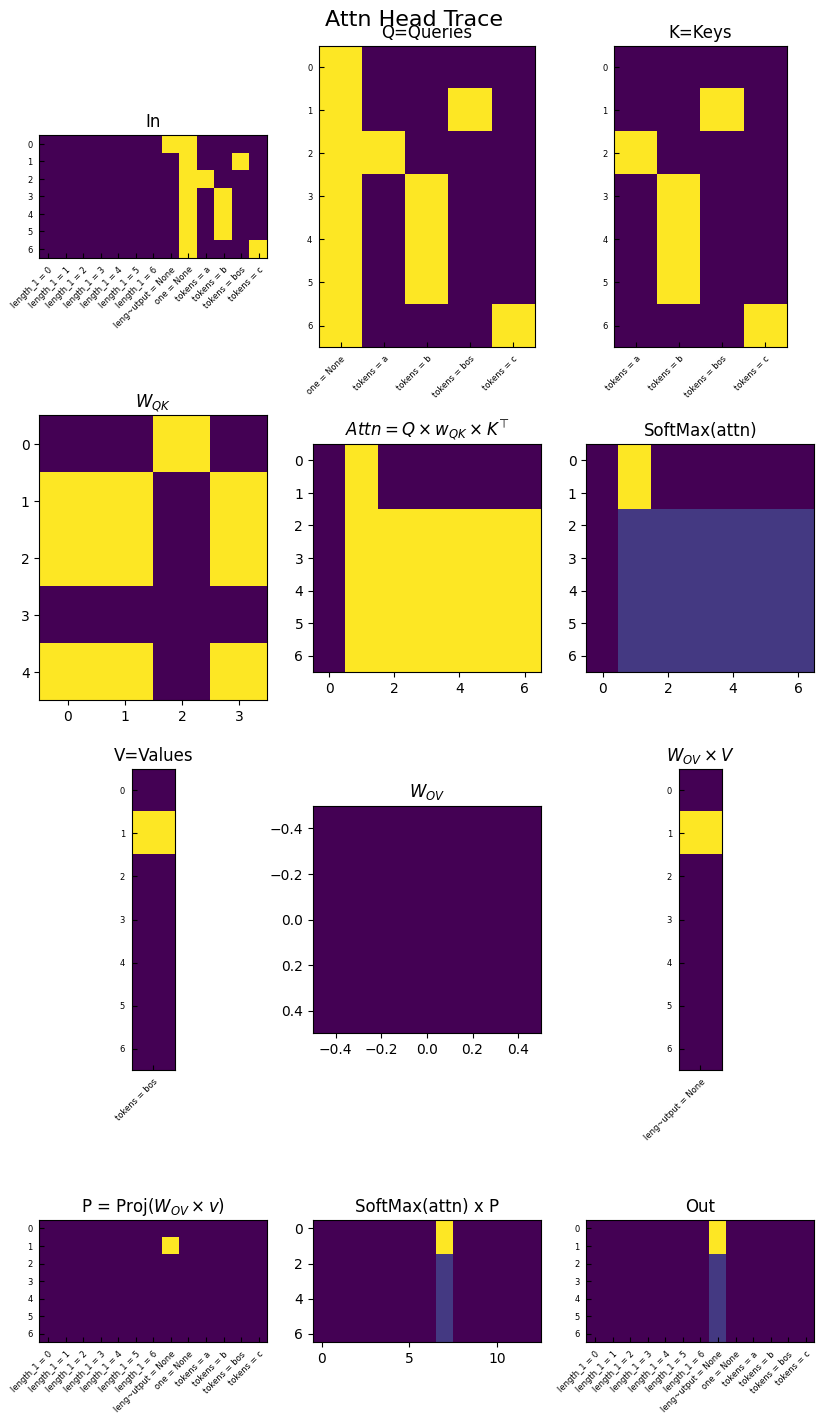

<Figure size 640x480 with 0 Axes>

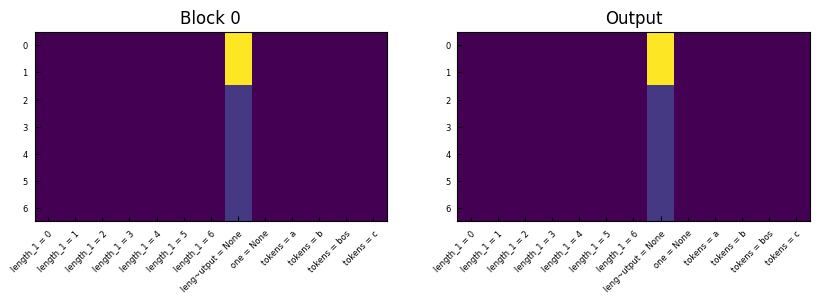

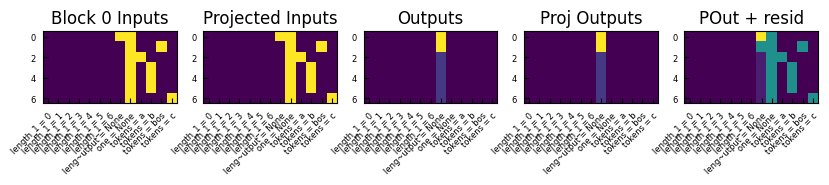

<Figure size 640x480 with 0 Axes>

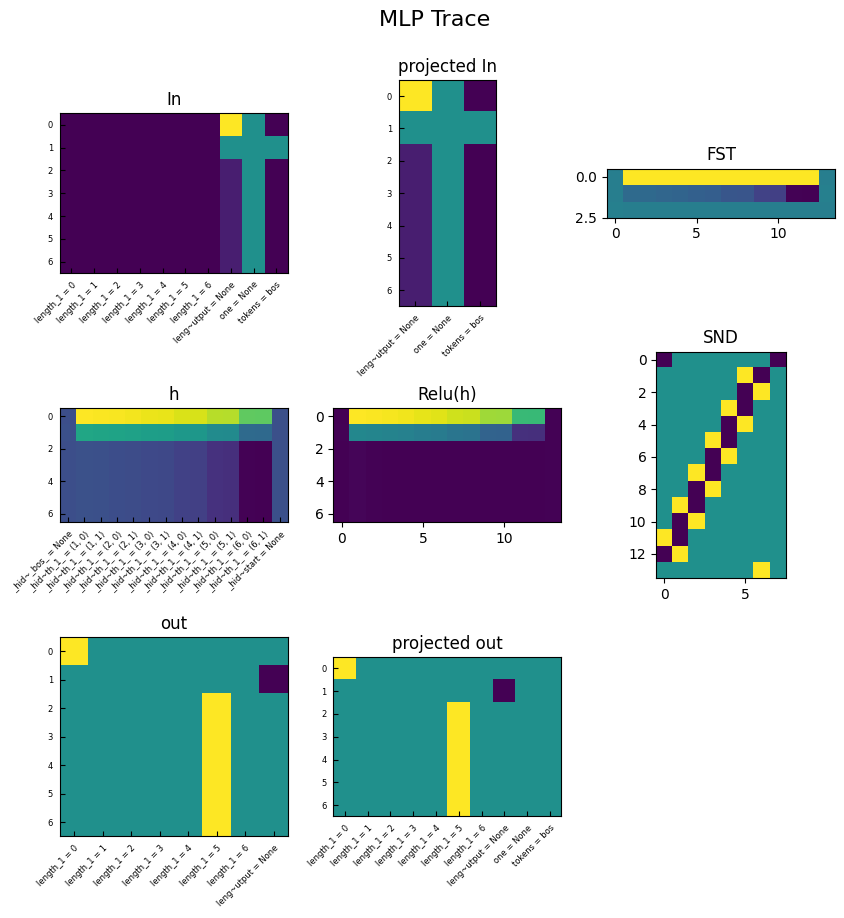

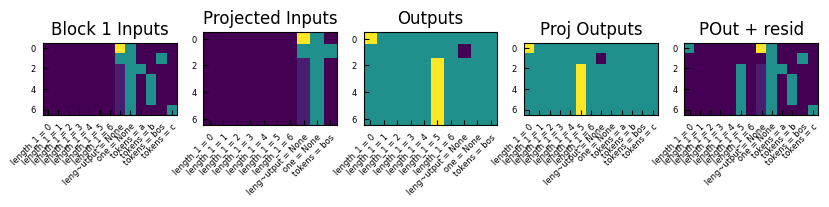

In [7]:
make_craft_model_verbose(craft_model)


from tracr.craft import bases
indices_space = bases.VectorSpaceWithBasis.from_values(
      rasp.indices.label, range(max_seq_len))
input_space = bases.join_vector_spaces(indices_space, craft_model.residual_space)


_BOS_DIRECTION = [basis.name for basis in craft_model.residual_space.basis if '_selector_width_attn_output' in basis.name][0]
_ONE_DIRECTION = 'one'

embedded_input = embed_input(formatted_input, input_space=input_space, _BOS_DIRECTION=_BOS_DIRECTION, _ONE_DIRECTION=_ONE_DIRECTION)

output_seq = craft_model.apply(embedded_input)

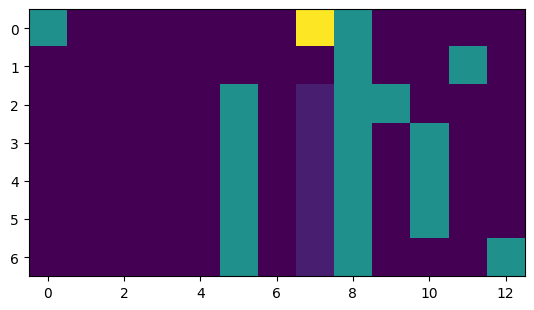

In [8]:
plt.imshow(output_seq.magnitudes)